## **Example. Stratified sampling in pre-election polling**

In [45]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import theano.tensor as tt
import arviz
import seaborn
import time
from scipy.special import expit as logistic
from scipy.special import logit
from scipy.special import softmax

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

In [3]:
%load_ext line_profiler

In [4]:
# arviz.style.use('arviz-darkgrid')

A survey of 1447 adults.

In [3]:
participants = 1447

This is the Table 8.2

In [4]:
data = pd.read_csv('data/cbs_survey.txt', sep=' ', skiprows=2, skipinitialspace=True, index_col=False)
data

,region,density,bush,dukakis,other,proportion
0,Northeast,I,0.298,0.617,0.085,0.032
1,Northeast,II,0.500,0.478,0.022,0.032
2,Northeast,III,0.467,0.413,0.120,0.115
3,Northeast,IV,0.464,0.522,0.014,0.048
4,Midwest,I,0.404,0.489,0.106,0.032
5,Midwest,II,0.447,0.447,0.106,0.065
6,Midwest,III,0.509,0.388,0.103,0.080
7,Midwest,IV,0.552,0.338,0.110,0.100
8,South,I,0.571,0.286,0.143,0.015
9,South,II,0.469,0.406,0.125,0.066


In [5]:
#data.density

We need the number of people of each region and each candidate.

In [6]:
data_obs = data[['bush', 'dukakis', 'other']].to_numpy()
print(data_obs)

[[0.298 0.617 0.085]
 [0.5   0.478 0.022]
 [0.467 0.413 0.12 ]
 [0.464 0.522 0.014]
 [0.404 0.489 0.106]
 [0.447 0.447 0.106]
 [0.509 0.388 0.103]
 [0.552 0.338 0.11 ]
 [0.571 0.286 0.143]
 [0.469 0.406 0.125]
 [0.515 0.404 0.081]
 [0.555 0.352 0.093]
 [0.5   0.471 0.029]
 [0.532 0.351 0.117]
 [0.54  0.371 0.089]
 [0.554 0.361 0.084]]


In [7]:
print(data_obs[:, 0] / (data_obs[:, 0] + data_obs[:, 1]), '\n')
print(1 - data_obs[:, 2])

[0.32568306 0.51124744 0.53068182 0.47058824 0.45240761 0.5
 0.56744705 0.62022472 0.66627771 0.536      0.56039173 0.61190739
 0.51493306 0.60249151 0.59275521 0.60546448] 

[0.915 0.978 0.88  0.986 0.894 0.894 0.897 0.89  0.857 0.875 0.919 0.907
 0.971 0.883 0.911 0.916]


In [8]:
proportion = data['proportion'].to_numpy() * participants
print(proportion)

[ 46.304  46.304 166.405  69.456  46.304  94.055 115.76  144.7    21.705
  95.502  98.396 182.322  33.281  76.691 124.442  82.479]


In [9]:
np.sum(proportion)

1444.106

In [10]:
print(data_obs.shape)
print(proportion.shape)

(16, 3)
(16,)


In [11]:
values = data_obs[:, :] * proportion.reshape(16, -1)
values = np.round(values)
np.sum(values)   # Check if the sum is equal to 1447

1447.0

In [12]:
values

array([[ 14.,  29.,   4.],
       [ 23.,  22.,   1.],
       [ 78.,  69.,  20.],
       [ 32.,  36.,   1.],
       [ 19.,  23.,   5.],
       [ 42.,  42.,  10.],
       [ 59.,  45.,  12.],
       [ 80.,  49.,  16.],
       [ 12.,   6.,   3.],
       [ 45.,  39.,  12.],
       [ 51.,  40.,   8.],
       [101.,  64.,  17.],
       [ 17.,  16.,   1.],
       [ 41.,  27.,   9.],
       [ 67.,  46.,  11.],
       [ 46.,  30.,   7.]])

### **Nonhierarchical model**

In [12]:
with pm.Model() as model_non_hiera:
    
    thetas = pm.Dirichlet('thetas', a=np.ones_like(data_obs), shape=(16, 3))
    post = pm.Multinomial('post', n=np.sum(values, axis=1), p=thetas, observed=values)

In [13]:
model_non_hiera.check_test_point()

thetas_stickbreaking__    -41.64
post                     -322.85
Name: Log-probability of test_point, dtype: float64

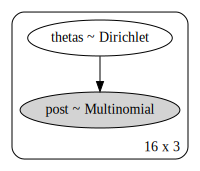

In [14]:
pm.model_to_graphviz(model_non_hiera)

In [15]:
with model_non_hiera:
    trace_1 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:13<00:00, 1229.44draws/s]


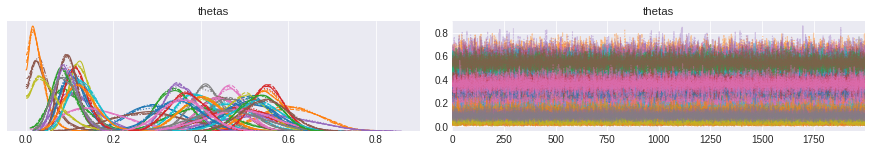

In [16]:
pm.traceplot(trace_1, var_names=['thetas']);

In [18]:
arviz.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"thetas[0,0]",0.300,0.064,0.184,0.424,0.000,0.000,16693.0,14799.0,16701.0,5847.0,1.0
"thetas[0,1]",0.600,0.068,0.474,0.727,0.001,0.000,15018.0,14778.0,14982.0,6380.0,1.0
"thetas[0,2]",0.100,0.042,0.033,0.185,0.000,0.000,14612.0,11216.0,14513.0,6030.0,1.0
"thetas[1,0]",0.490,0.071,0.362,0.623,0.001,0.000,19890.0,19890.0,19769.0,5557.0,1.0
"thetas[1,1]",0.469,0.071,0.341,0.604,0.001,0.000,18397.0,16708.0,18280.0,6221.0,1.0
"thetas[1,2]",0.041,0.027,0.001,0.089,0.000,0.000,13983.0,8384.0,13998.0,5573.0,1.0
"thetas[2,0]",0.465,0.038,0.394,0.534,0.000,0.000,20043.0,19863.0,20038.0,5672.0,1.0
"thetas[2,1]",0.412,0.038,0.344,0.486,0.000,0.000,20367.0,19791.0,20372.0,5545.0,1.0
"thetas[2,2]",0.124,0.025,0.076,0.169,0.000,0.000,19117.0,15634.0,19928.0,5515.0,1.0
"thetas[3,0]",0.459,0.057,0.355,0.570,0.000,0.000,18824.0,17674.0,18744.0,4945.0,1.0


Now, the goal is to reproduce the figure 8.1 (a).

In [18]:
with model_non_hiera:
    ppc_non_hiera = pm.sample_posterior_predictive(trace_1, var_names=['thetas', 'post'])

100%|██████████| 8000/8000 [00:12<00:00, 638.87it/s]


In [19]:
ppc_non_hiera['thetas'].shape

(8000, 16, 3)

Just check if the column **proportion** (look at the data frame) is equal to what we got.

In [20]:
proportion / np.sum(proportion)

array([0.03206413, 0.03206413, 0.11523046, 0.04809619, 0.03206413,
       0.06513026, 0.08016032, 0.1002004 , 0.01503006, 0.06613226,
       0.06813627, 0.12625251, 0.02304609, 0.05310621, 0.08617234,
       0.05711423])

In [21]:
diff = []

for i in range(16):
    result = ppc_non_hiera['thetas'][:, i, 0] - ppc_non_hiera['thetas'][:, i, 1]
    diff.append(list(result))

In [22]:
diff = np.asarray(diff)
diff

array([[-0.12250978, -0.42556044, -0.15966997, ..., -0.22926153,
        -0.24760069, -0.24930177],
       [ 0.07019904, -0.02395537, -0.06649436, ...,  0.26462965,
         0.26716916,  0.29235914],
       [ 0.05685179, -0.03017662,  0.13384658, ...,  0.10394146,
        -0.00056104,  0.06779968],
       ...,
       [ 0.25018806,  0.11635687,  0.2790056 , ...,  0.16693184,
         0.16900893,  0.21247109],
       [ 0.09925011,  0.25388441,  0.16680238, ...,  0.08845875,
         0.12992982,  0.15282509],
       [ 0.12496571,  0.22629916,  0.21195712, ...,  0.17396249,
         0.16813381,  0.12199068]])

In [23]:
result = np.sum(diff.T * proportion / np.sum(proportion), axis=1)

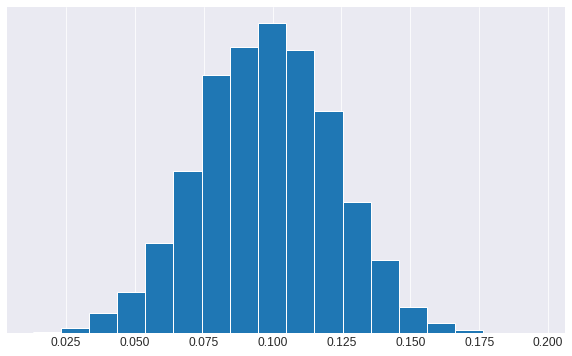

In [24]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result, bins=18, edgecolor='w', density=True)
plt.yticks([]);

In [25]:
np.mean(result)

0.09773008630792071

The figure is almost the same!

### **Hierarchichal model**

The authors are using other parameters, so we need to find the number of people for $\alpha_{1j}$ and $\alpha_{2j}$.

In [13]:
values

array([[ 14.,  29.,   4.],
       [ 23.,  22.,   1.],
       [ 78.,  69.,  20.],
       [ 32.,  36.,   1.],
       [ 19.,  23.,   5.],
       [ 42.,  42.,  10.],
       [ 59.,  45.,  12.],
       [ 80.,  49.,  16.],
       [ 12.,   6.,   3.],
       [ 45.,  39.,  12.],
       [ 51.,  40.,   8.],
       [101.,  64.,  17.],
       [ 17.,  16.,   1.],
       [ 41.,  27.,   9.],
       [ 67.,  46.,  11.],
       [ 46.,  30.,   7.]])

In [14]:
alpha_2j = np.round((1 - data['other'].to_numpy()) * proportion) #Not a probability as you may see
print(alpha_2j)

[ 42.  45. 146.  68.  41.  84. 104. 129.  19.  84.  90. 165.  32.  68.
 113.  76.]


In [15]:
alpha_1j = values[:, 0] / (values[:, 0] + values[:, 1]) * proportion #Not a probability as you may see
print(alpha_1j)

[ 15.07572093  23.66648889  88.29653061  32.68517647  20.94704762
  47.0275      65.67153846  89.73643411  14.47        51.16178571
  55.14501099 111.60316364  17.14475758  46.24016176  73.78419469
  49.9215    ]


In [16]:
new_values = np.round(np.stack([alpha_1j, alpha_2j], axis=1))
print(new_values)

[[ 15.  42.]
 [ 24.  45.]
 [ 88. 146.]
 [ 33.  68.]
 [ 21.  41.]
 [ 47.  84.]
 [ 66. 104.]
 [ 90. 129.]
 [ 14.  19.]
 [ 51.  84.]
 [ 55.  90.]
 [112. 165.]
 [ 17.  32.]
 [ 46.  68.]
 [ 74. 113.]
 [ 50.  76.]]


In [17]:
np.round((data.other.to_numpy() * proportion * (values[:, 0] + values[:, 1]) - values[:, 0]) / (values[:, 0] + values[:, 1]))

array([ 4.,  1., 19.,  1.,  4.,  9., 11., 15.,  2., 11.,  7., 16.,  0.,
        8., 10.,  6.])

In [18]:
np.sum(new_values, axis=1)

array([ 57.,  69., 234., 101.,  62., 131., 170., 219.,  33., 135., 145.,
       277.,  49., 114., 187., 126.])

Signature:
tt.nnet.h_softmax(
    x,
    batch_size,
    n_outputs,
    n_classes,
    n_outputs_per_class,
    W1,
    b1,
    W2,
    b2,
    target=None,
)
Docstring:
Two-level hierarchical softmax.

This function implements a two-layer hierarchical softmax. It is commonly
used as an alternative of the softmax when the number of outputs is
important (it is common to use it for millions of outputs). See
reference [1]_ for more information about the computational gains.

The `n_outputs` outputs are organized in `n_classes` classes, each class
containing the same number `n_outputs_per_class` of outputs.
For an input `x` (last hidden activation), the first softmax layer predicts
its class and the second softmax layer predicts its output among its class.

If `target` is specified, it will only compute the outputs of the
corresponding targets. Otherwise, if `target` is `None`, it will compute
all the outputs.

The outputs are grouped in classes in the same order as they are initially
defi

In [101]:
with pm.Model() as model_hier:
    
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.Exponential.dist(1))
    L = pm.expand_packed_triangular(2, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    mu = pm.Normal('mu', 0, 0.01, shape=2)
#     mu = pm.Uniform('mu', -0.5, 0.5, shape=2)
#     mu = pm.Normal('mu', 0., 0.01, shape=2, testval=new_values.mean(axis=0))
    beta = pm.MvNormal('beta', mu=mu, chol=L, shape=(16, 2))
    
    alpha = tt.nnet.softmax(beta)
    
#     alphas = pm.Dirichlet('alphas', a=alpha, shape=(16, 2))

    post = pm.Multinomial('post', n=np.sum(new_values, axis=1), p=alpha, observed=new_values)

In [102]:
model_hier.check_test_point()

packed_L_cholesky-cov-packed__     -1.71
mu                                  7.37
beta                              -29.41
post                             -105.64
Name: Log-probability of test_point, dtype: float64

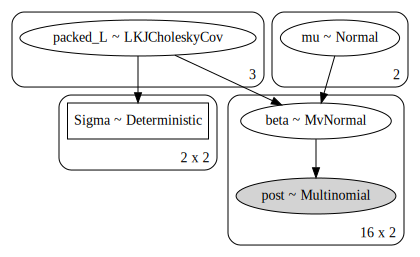

In [24]:
pm.model_to_graphviz(model_hier)

In [103]:
with model_hier:
    prior_sample = pm.sample_prior_predictive(samples=5_000)

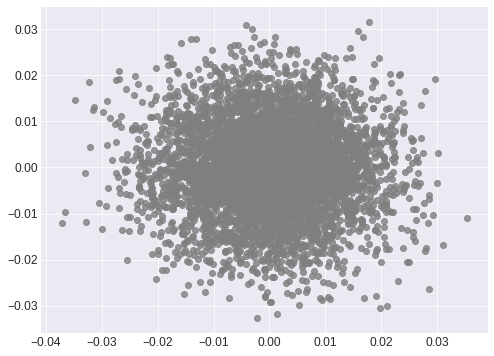

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(
    prior_sample['mu'][:, 0], 
    prior_sample['mu'][:, 1], 'o', color='C7', alpha=0.8);

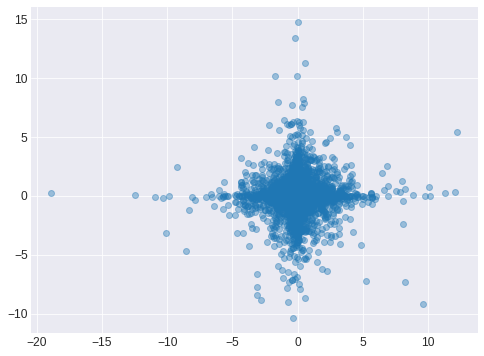

In [105]:
plt.figure(figsize=(8, 6))
plt.plot(
    prior_sample['beta'][:, 0], 
    prior_sample['beta'][:, 1], 'o', alpha=0.4);

In [106]:
softmax(prior_sample['beta'], axis=1)[:, 0]

array([0.89705107, 0.4222884 , 0.01865691, ..., 0.61285104, 0.3037912 ,
       0.08469206])

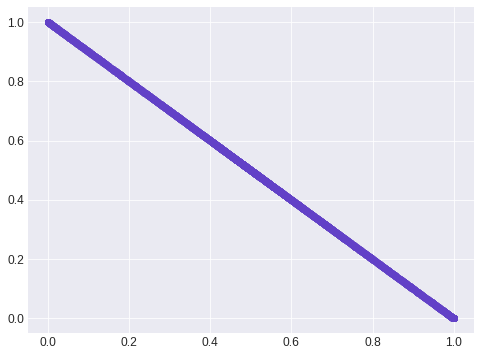

In [107]:
plt.figure(figsize=(8, 6))
plt.plot(
    softmax(prior_sample['beta'], axis=1)[:, 0],
    softmax(prior_sample['beta'], axis=1)[:, 1], 'o', color='xkcd:bluey purple', alpha=0.4);

In [108]:
with model_hier:
    trace_2 = pm.sample(draws=1_000, tune=5_000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu, packed_L]
Sampling 4 chains, 261 divergences: 100%|██████████| 24000/24000 [04:03<00:00, 98.74draws/s] 
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6731413512132158, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [109]:
arviz.summary(trace_2, var_names=['mu', 'beta'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],-0.002,0.011,-0.022,0.016,0.001,0.001,115.0,115.0,121.0,2472.0,1.03
mu[1],0.002,0.010,-0.017,0.020,0.000,0.000,768.0,768.0,786.0,2194.0,1.01
"beta[0,0]",-0.457,0.489,-1.347,0.300,0.066,0.047,56.0,56.0,61.0,142.0,1.05
"beta[0,1]",0.374,0.466,-0.410,1.272,0.034,0.024,183.0,183.0,160.0,1617.0,1.03
"beta[1,0]",-0.284,0.376,-0.986,0.391,0.021,0.015,324.0,324.0,276.0,1405.0,1.02
"beta[1,1]",0.234,0.372,-0.418,0.952,0.020,0.014,363.0,363.0,349.0,1316.0,1.02
"beta[2,0]",-0.252,0.351,-0.865,0.404,0.016,0.011,480.0,480.0,391.0,1437.0,1.01
"beta[2,1]",0.221,0.352,-0.398,0.881,0.017,0.012,412.0,412.0,281.0,1412.0,1.02
"beta[3,0]",-0.342,0.386,-1.065,0.362,0.023,0.016,285.0,285.0,272.0,1259.0,1.02
"beta[3,1]",0.284,0.393,-0.380,1.058,0.026,0.018,231.0,231.0,176.0,1405.0,1.02


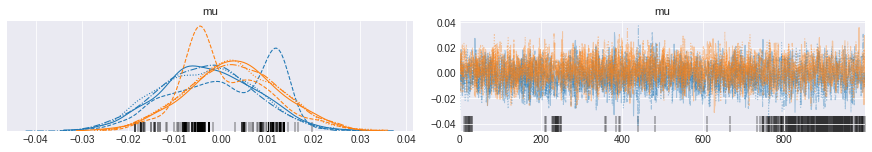

In [110]:
pm.traceplot(trace_2, var_names=['mu']);
# arviz.plot_trace(trace_2, var_names=['mu']);

In [111]:
logistic(trace_2['mu'].mean(axis=0))

array([0.49950145, 0.50053649])

If you want to check the covariance matrix

In [112]:
matrix_s = trace_2['Sigma'].mean(axis=0)

In [113]:
matrix_s

array([[0.24829784, 0.04870112],
       [0.04870112, 0.20169156]])

From that, you get $\tau_1$ and $\tau_2$

In [114]:
tau1, tau2 = np.sqrt(matrix_s[0, 0]), np.sqrt(matrix_s[1, 1])
print(tau1, tau2)

0.4982949349217773 0.4491008335858505


And then $\rho$

In [115]:
rho = matrix_s[1, 0] / (tau1 * tau2)

In [116]:
rho

0.21762489903736582

Now, the goal is to reproduce the figure 8.1 (b).

In [117]:
with model_hier:
    ppc_hier = pm.sample_posterior_predictive(trace_2, var_names=['beta'])
    
ppc_hier['beta'] = softmax(ppc_hier['beta'], axis=2)

100%|██████████| 4000/4000 [00:00<00:00, 19663.07it/s]


In [121]:
print(ppc_hier['beta'][:15, 0, :])

[[0.33582516 0.66417484]
 [0.36164233 0.63835767]
 [0.3054917  0.6945083 ]
 [0.3391067  0.6608933 ]
 [0.31359315 0.68640685]
 [0.28545371 0.71454629]
 [0.25450457 0.74549543]
 [0.29067865 0.70932135]
 [0.24731029 0.75268971]
 [0.28260285 0.71739715]
 [0.29444538 0.70555462]
 [0.26837252 0.73162748]
 [0.26837252 0.73162748]
 [0.26837252 0.73162748]
 [0.26837252 0.73162748]]


In [122]:
ppc_hier['beta'].shape

(4000, 16, 2)

In [123]:
values[:, 0] / (values[:, 0] + values[:, 1])

array([0.3255814 , 0.51111111, 0.53061224, 0.47058824, 0.45238095,
       0.5       , 0.56730769, 0.62015504, 0.66666667, 0.53571429,
       0.56043956, 0.61212121, 0.51515152, 0.60294118, 0.59292035,
       0.60526316])

Remember that from 

\begin{align}
    \alpha_{1j} &= \dfrac{\theta_{1j}}{\theta_{1j} + \theta_{2j}} \\
    \alpha_{2j} &= 1 - \theta_{3j}
\end{align}

you can get $\theta_{1j}$ and $\theta_{2j}$

In [124]:
th1 = []

for i in range(16):
    result1 =  2 * ppc_hier['beta'][:, i, 0] * ppc_hier['beta'][:, i, 1] - ppc_hier['beta'][:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th1.append(list(result1))

In [125]:
th1 = np.asarray(th1)
th1.shape
th1 = th1.T

In [126]:
th1

array([[-0.2180816 , -0.2583519 , -0.23294731, ..., -0.07233225,
        -0.09611557, -0.11400131],
       [-0.17664335, -0.18725471, -0.13093216, ..., -0.02297447,
        -0.17385674, -0.13187119],
       [-0.27017526, -0.11269503, -0.09072602, ..., -0.13748094,
        -0.0858593 , -0.17488378],
       ...,
       [-0.15250138, -0.02704045, -0.06015266, ..., -0.1388382 ,
        -0.07947211, -0.10776233],
       [-0.41835618, -0.23290852, -0.24437551, ..., -0.05594035,
        -0.14824358, -0.08808137],
       [-0.38614573, -0.22197272, -0.23666338, ..., -0.12101195,
        -0.15251382, -0.0698187 ]])

In [127]:
result2 = np.sum(th1 * proportion / np.sum(proportion), axis=1)
result2[:15]

array([-0.13382952, -0.12666883, -0.11288486, -0.1406659 , -0.13906812,
       -0.12450764, -0.13903533, -0.13287531, -0.12785005, -0.15845967,
       -0.15170453, -0.15352308, -0.15352308, -0.15352308, -0.15352308])

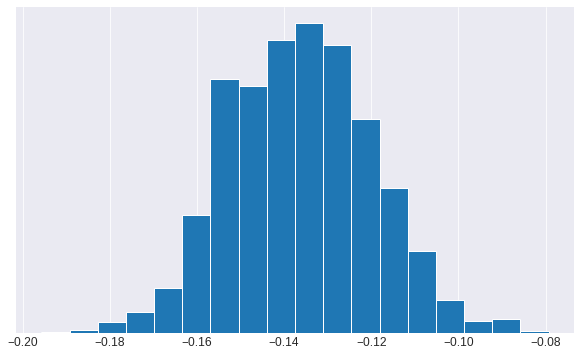

In [128]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result2 , bins=18, edgecolor='w', density=True)
#plt.xlim(0.09, .16)
plt.yticks([]);

As you can see, the figure is quite similar, except that there is a minus sing. The next step would be the model checking, but it would be pointless (you could do it) and the results would not be right.

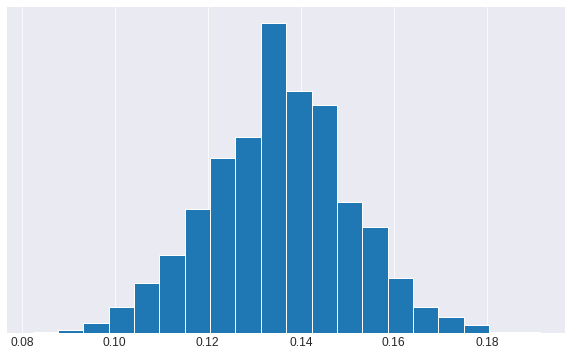

In [82]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(-result2 , bins=20, edgecolor='w', density=True) # With a minus
plt.yticks([]);

Why? I don't know, nevertheless, it is really weird.

In [93]:
%load_ext watermark

In [94]:
%watermark -iv -v -p theano,scipy,matplotlib -m

numpy   1.18.1
pandas  1.0.1
pymc3   3.8
seaborn 0.10.0
arviz   0.7.0
CPython 3.7.6
IPython 7.12.0

theano 1.0.4
scipy 1.4.1
matplotlib 3.1.3

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-91-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


## **With pystan**

This section is to reproduce the figure 8.1 (a) and the figure 8.1 (b) with Stan.

In [129]:
import pystan
print(pystan.__version__)

2.19.1.1


In [159]:
modelo="""
data {
  int<lower=0> N;
  int<lower=0> n;
  int y_obs[N, n];
  vector[n] alpha;
}

parameters {
  
  simplex[n] theta[N];
}

model {
  
  for (i in 1:N)
    theta[i] ~ dirichlet(alpha);
  
  for (i in 1:N)
    y_obs[i] ~ multinomial(theta[i]);
}

"""

In [160]:
stan_modelo = pystan.StanModel(model_code=modelo)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a28c5090c429737936718a5aee45413 NOW.


In [161]:
data2 = {'N': 16,
       'n': 3,
       'alpha': [1,1,1],
       'y_obs': values.astype(int)}

In [162]:
fit = stan_modelo.sampling(data=data2)

In [163]:
print(fit.stansummary(digits_summary=3))

Inference for Stan model: anon_model_2a28c5090c429737936718a5aee45413.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1,1]    0.299 7.95e-4  0.063   0.182   0.254   0.297   0.342   0.431   6344  1.001
theta[2,1]    0.489 8.84e-4  0.071   0.349    0.44   0.489   0.537   0.632   6476  0.999
theta[3,1]    0.465 4.85e-4  0.038   0.391   0.439   0.465    0.49   0.538   6069    1.0
theta[4,1]    0.458 7.69e-4  0.058   0.347   0.419   0.457   0.497   0.573   5595    1.0
theta[5,1]    0.399 9.03e-4   0.07   0.268   0.349   0.398   0.446   0.538   5994  0.999
theta[6,1]    0.443 6.25e-4  0.051   0.344   0.408   0.442   0.478   0.542   6674    1.0
theta[7,1]    0.505 5.68e-4  0.045    0.42   0.475   0.505   0.534   0.594   6152    1.0
theta[8,1]    0.547 5.22e-4   0.04   0.468    0.52   0.548   0.575   0.626   5937  0.999
theta[9,1]

In [164]:
samples = fit.extract(permuted=True)['theta']

In [165]:
samples.shape

(4000, 16, 3)

In [166]:
samples[0, :, 0]

array([0.305646  , 0.47988473, 0.42721749, 0.46774404, 0.44612915,
       0.51697408, 0.58440693, 0.53752915, 0.63354365, 0.4760622 ,
       0.56491333, 0.60691645, 0.62535855, 0.42935015, 0.535791  ,
       0.56380083])

In [167]:
np.mean(samples[:, 0, 2])

0.09984042335668665

In [168]:
diff3 = []

for i in range(16):
    result3 = samples[:, i, 0] - samples[:, i, 1]
    diff3.append(list(result3))

In [169]:
diff3 = np.asarray(diff3)
diff3

array([[-0.29830963, -0.20967514, -0.26950832, ..., -0.35826107,
        -0.33491419, -0.23189027],
       [-0.02413558, -0.21438899, -0.10612351, ..., -0.02959419,
         0.06178593,  0.0923874 ],
       [-0.02366946,  0.02613382,  0.11743479, ...,  0.06990543,
         0.11012108,  0.17011507],
       ...,
       [ 0.1281835 ,  0.30301716,  0.14321119, ...,  0.1655299 ,
         0.13558499,  0.28890727],
       [ 0.16218526,  0.22916085,  0.10451857, ...,  0.31905207,
         0.16814509,  0.13835418],
       [ 0.2052175 ,  0.2833933 ,  0.11942988, ...,  0.12966828,
         0.09326143,  0.22236906]])

In [170]:
diff3[:, 3999]

array([-0.23189027,  0.0923874 ,  0.17011507, -0.3350024 , -0.06830835,
       -0.11070815,  0.07650463,  0.28555088,  0.16222205,  0.04862792,
       -0.04044725,  0.01634078, -0.19855381,  0.28890727,  0.13835418,
        0.22236906])

In [171]:
res2 = np.sum(diff3.T * proportion / np.sum(proportion), axis=1)

In [172]:
res2.shape

(4000,)

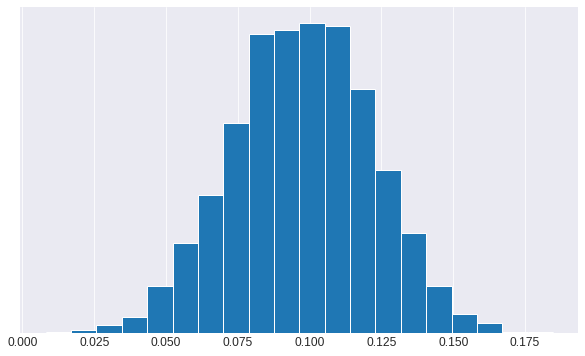

In [173]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res2, bins=20, edgecolor='w', density=True)
plt.yticks([]);
# plt.savefig('model_non_hier.png', dpi=120)

With this, the figure 8.1 (a) is very similiar to this one.

### **Pystan with the hierarchical model**

In [132]:
modelo2 = """
data {
  int<lower=0> N;
  int<lower=0> n;
  int post[N, n];
}

parameters {
  vector[n] mu;
  cholesky_factor_corr[n] L;
  vector[n] beta[N];
    
}

transformed parameters{
  vector[n] theta[N] ;
  
  for (i in 1:N)
    theta[i] = inv_logit(beta[i]);
     
}

model {

  L ~ lkj_corr_cholesky(3.0);
 
  mu ~ exponential(0.01);
  
  beta ~ multi_normal_cholesky(mu, L);
  
    
  for (i in 1:N)
    post[i] ~ multinomial(theta[i]);
  
}

generated quantities {

  corr_matrix[n] Sigma;
  Sigma = multiply_lower_tri_self_transpose(L);
  
}


"""

modelo3 = """
data {
  int<lower=0> N;
  int<lower=0> n;
  int post[N, n];
}

parameters {
  vector[n] mu;
  cholesky_factor_corr[n] L;
  vector[n] beta[N];
  simplex[n] thetas[N];
  
}

transformed parameters{
  
  vector<lower=0, upper=1>[n] alphas[N];
  
  
  for (i in 1:N)
    alphas[i] = softmax(beta[i]);
   
}

model {

  L ~ lkj_corr_cholesky(3.0);
 
  mu ~ normal(0, .01);
  
  beta ~ multi_normal_cholesky(mu, L);
  
  for (i in 1:N)
    thetas[i] ~ dirichlet(alphas[i]);
  
  for (i in 1:N)
    post[i] ~ multinomial(alphas[i]);
  
}

generated quantities {

  corr_matrix[n] Sigma;
  Sigma = multiply_lower_tri_self_transpose(L);
  
}

 
"""

In [133]:
stan_modelo2 = pystan.StanModel(model_code=modelo3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_18738fd7d802e41a14daf6d0e4aad6e0 NOW.


In [134]:
data3 = {'N': 16,
         'n': 2,
         'post': new_values.astype(int)}

In [135]:
fit2 = stan_modelo2.sampling(data=data3, iter=5000, verbose=True, control={'adapt_delta':0.90}, init=0)

In [136]:
print(fit2.stansummary(digits_summary=3))

Inference for Stan model: anon_model_18738fd7d802e41a14daf6d0e4aad6e0.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                mean  se_mean       sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
mu[1]         -0.002  6.89e-5     0.01  -0.021  -0.008  -0.002   0.005   0.018  20619    1.0
mu[2]          0.002  7.23e-5     0.01  -0.018  -0.005   0.002   0.009   0.022  19414    1.0
L[1,1]           1.0      nan      0.0     1.0     1.0     1.0     1.0     1.0    nan    nan
L[2,1]         0.737    0.001    0.137   0.385    0.68   0.767   0.831   0.905   9163    1.0
L[1,2]           0.0      nan      0.0     0.0     0.0     0.0     0.0     0.0    nan    nan
L[2,2]         0.649    0.001    0.128   0.425   0.556   0.641   0.733   0.923  14384    1.0
beta[1,1]     -0.446     0.01    0.927  -2.209  -1.069   -0.46    0.17   1.377   8129    1.0
beta[2,1]     -0.284     0.01    0.946  -2.162  -0.916  -0.286   0

In [151]:
samples2 = fit2.extract(permuted=True)['beta']

In [152]:
samples2 = softmax(samples2, axis=2)

In [153]:
samples2[:10, 4, :]

array([[0.32363442, 0.67636558],
       [0.39600414, 0.60399586],
       [0.36065595, 0.63934405],
       [0.32982244, 0.67017756],
       [0.35618454, 0.64381546],
       [0.38430935, 0.61569065],
       [0.402073  , 0.597927  ],
       [0.3404694 , 0.6595306 ],
       [0.41749458, 0.58250542],
       [0.32197246, 0.67802754]])

In [154]:
th5 = []

for i in range(16):
    res5 =  2 * samples2[:, i, 0] * samples2[:, i, 1] - samples2[:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th5.append(list(res5))

In [155]:
th5 = np.asarray(th5)
th5.shape

(16, 10000)

In [156]:
result5 = np.sum(th5.T * proportion / np.sum(proportion), axis=1)
print(result5.shape)
result5[:15]

(10000,)


array([-0.16317686, -0.13144722, -0.15993167, -0.13796937, -0.15175436,
       -0.13930074, -0.13661417, -0.1265063 , -0.11742489, -0.18464812,
       -0.15224667, -0.16219158, -0.11969181, -0.16735025, -0.13077128])

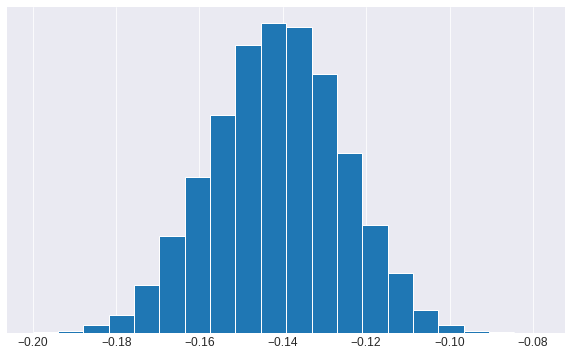

In [157]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result5 , bins=20, edgecolor='w', density=True)
plt.yticks([]);
# plt.savefig('model_hier.png', dpi=120)

Again, very similar to the figure 8.1 (b), except for a minus sign. Why? It is not clear at the moment.